## Решить задачу классификации текстов на рекламные и информационные     


---

**ФИО: Шатаров Кирилл Александрович**   
**Группа: 211-365**

---

Основные пункты задания на практику.
1. Найти датасет по выбранной тематике
2. Загрузить датасет. Провести предобработку датасета.
3. Создать архитектуру сети.
4. Обучить нейронную сеть и проанализировать результаты.
5. Составить отчет о практике.

**Рекламные статьи Википедии**   
Многоцелевой набор данных статей Википедии, отмеченных как рекламные и «хорошие»   
Ссылка на данные: https://www.kaggle.com/datasets/urbanbricks/wikipedia-promotional-articles?resource=download&select=good.csv

---

**Содержание**   
Этот набор данных состоит из статей, которые были отмечены пользователями как имеющие «рекламный тон» (promotional.csv), и статей, которые были отмечены как «хорошие статьи» (good.csv).

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import os
import re
import pickle
import plotly

### Загрузка и обработка данных

In [154]:
good = pd.read_csv('good.csv')
good.head()

,text,url
0,Nycticebus linglom is a fossil strepsirrhine p...,https://en.wikipedia.org/wiki/%3F%20Nycticebus...
1,Oryzomys pliocaenicus is a fossil rodent from ...,https://en.wikipedia.org/wiki/%3F%20Oryzomys%2...
2,.hack dt hk is a series of single player actio...,https://en.wikipedia.org/wiki/.hack%20%28video...
3,The You Drive Me Crazy Tour was the second con...,https://en.wikipedia.org/wiki/%28You%20Drive%2...
4,0 8 4 is the second episode of the first seaso...,https://en.wikipedia.org/wiki/0-8-4


In [155]:
good.shape

(30279, 2)

In [156]:
good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30279 entries, 0 to 30278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30279 non-null  object
 1   url     30279 non-null  object
dtypes: object(2)
memory usage: 473.2+ KB


In [157]:
promo = pd.read_csv('promotional.csv')
promo.head()

,text,advert,coi,fanpov,pr,resume,url
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",0,0,1,0,0,https://en.wikipedia.org/wiki/1%20Litre%20no%2...
1,"1DayLater was free, web based software that wa...",1,1,0,0,0,https://en.wikipedia.org/wiki/1DayLater
2,1E is a privately owned IT software and servic...,1,0,0,0,0,https://en.wikipedia.org/wiki/1E
3,1Malaysia pronounced One Malaysia in English a...,1,0,0,0,0,https://en.wikipedia.org/wiki/1Malaysia
4,"The Jerusalem Biennale, as stated on the Bienn...",1,0,0,0,0,https://en.wikipedia.org/wiki/1st%20Jerusalem%...


In [158]:
promo.shape

(23837, 7)

In [159]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23837 entries, 0 to 23836
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23837 non-null  object
 1   advert  23837 non-null  int64 
 2   coi     23837 non-null  int64 
 3   fanpov  23837 non-null  int64 
 4   pr      23837 non-null  int64 
 5   resume  23837 non-null  int64 
 6   url     23837 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.3+ MB


In [160]:
# Удаление ненужных столбцов
good.drop('url', axis= 1 , inplace= True)
promo.drop(['advert', 'coi', 'fanpov', 'pr', 'resume', 'url'], axis= 1 , inplace= True)

Объединяем оба показателя в один кадр данных и добавляем метки: для рекламных - 1, для "хороших" - 0.

In [161]:
good.insert(1, 'label', 0)
promo.insert(1, 'label', 1)

In [162]:
promo.head()

,text,label
0,"1 Litre no Namida 1, lit. 1 Litre of Tears als...",1
1,"1DayLater was free, web based software that wa...",1
2,1E is a privately owned IT software and servic...,1
3,1Malaysia pronounced One Malaysia in English a...,1
4,"The Jerusalem Biennale, as stated on the Bienn...",1


In [163]:
# Объединение датасетов в один
df = pd.concat((good, promo), ignore_index=True, axis=0)

In [164]:
# Перемешаем данные
df = df.reindex(np.random.permutation(df.index))
df.head(10)

,text,label
48024,Scott Robinson and Charlene Mitchell are ficti...,1
23115,Robert of Cricklade c. 1100117479 was a mediev...,0
29977,The yellow lipped sea krait Laticauda colubrin...,0
48909,Veronika Scott is an American social entrepren...,1
4684,1992 1993 1994 1995 The bombing of Banski dvor...,0
6813,Miguel Gregory Comminges born 16 March 1982 is...,0
10089,Flaming Pie is the tenth solo studio album by ...,0
53167,Robert Wendel is an American composer of class...,1
8997,"Takahito Eguchi , Eguchi Takahito, born August...",0
28261,Valencia Valencian Valencia is one of the 52 c...,0


In [165]:
# Разделение данных на обучающую и тестовую
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

### Обработка текста. Токенизация

In [35]:
# Задание параметров преобразования
VOCAB_SIZE = 50000        # максимальное количество слов, которые будут использоваться
SEQUENCE_LENGTH = 400     # максимальное количество слов в каждой последовательности

In [47]:
train_data = [str(txt) for txt in df_train['text'].values] # Преобразование текстовых данных в строки
test_data = [str(txt) for txt in df_test['text'].values]

# Создание токенайзера
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    oov_token='unknown_word',
    char_level=False
)

tokenizer.fit_on_texts(train_data)  # Обучение токенайзера (составление словаря)
items = list(tokenizer.word_index.items())

In [48]:
# Вывод нескольких встречающихся слов из словаря
print(items[:10])
print("Размер словаря", len(items))

[('unknown_word', 1), ('the', 2), ('of', 3), ('and', 4), ('in', 5), ('to', 6), ('a', 7), ('was', 8), ('on', 9), ('for', 10)]
Размер словаря 688495


In [49]:
x_train = tokenizer.texts_to_sequences(train_data)  # векторизация набора данных
x_test = tokenizer.texts_to_sequences(test_data)

# x_test = np.array(tokenizer.texts_to_sequences(test_data))

In [50]:
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", train_data[1][:82])
print("Он же в виде последовательности индексов: ", x_train[1][:19])

Фрагмент обучающего текста:
В виде оригинального текста:               UEM Edgenta Berhad MYX 1368, UEM Edgenta is one of Malaysia's largest total asset 
Он же в виде последовательности индексов:  [1, 1, 27290, 1, 1, 1, 1, 15, 34, 3, 20595, 586, 377, 6772, 2475, 2223, 1096, 9, 2]


In [51]:
# Преобразуем данные в фиксированную форму
x_train = sequence.pad_sequences(x_train, maxlen=SEQUENCE_LENGTH)
x_test = sequence.pad_sequences(x_test, maxlen=SEQUENCE_LENGTH)

In [53]:
print(x_train.shape)
print(x_test.shape)

(43292, 400)
(10824, 400)


In [52]:
# Получение меток
y_train = df_train['label'].values
y_test = df_test['label'].values

## Создание модели

В модель добавляем слой встраивания (Embedding). Слой встраивания - это просто матрица, каждая строка которой соответствует представлению слова в словаре. Каждое представление - это одномерный вектор вещественных чисел, который изучается в процессе обучения.   
Создаем слой встраивания, задавая входной размер отображения (количество слов в словаре + 1), выходной размер (длина векторного представления) и входную длину (количество слов в последовательности). Добавляем 1 к размеру словаря, потому что 0 - это зарезервированное значение, которое используется для подстановки.   
1. input_dim: размер словаря, то есть количество уникальных токенов.   
2. output_dim: размер векторов, в которые будут преобразовываться слова. Это размерность выходных векторов.   
3. input_length: длина входной последовательности (количество слов в каждом входном образце).

In [55]:
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH))
model.add(LSTM(80))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [58]:
EPOCHS = 5
BATCH_SIZE = 64

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.15)

Epoch 1/5
575/575 [==============================] - 573s 998ms/step - loss: 0.3132 - accuracy: 0.8897 - val_loss: 0.3438 - val_accuracy: 0.8810
Epoch 2/5
575/575 [==============================] - 603s 1s/step - loss: 0.3010 - accuracy: 0.8786 - val_loss: 0.3542 - val_accuracy: 0.8548
Epoch 3/5
575/575 [==============================] - 609s 1s/step - loss: 0.2152 - accuracy: 0.9272 - val_loss: 0.3300 - val_accuracy: 0.9004
Epoch 4/5
575/575 [==============================] - 609s 1s/step - loss: 0.2609 - accuracy: 0.8952 - val_loss: 0.3279 - val_accuracy: 0.8991
Epoch 5/5
575/575 [==============================] - 614s 1s/step - loss: 0.1602 - accuracy: 0.9439 - val_loss: 0.3276 - val_accuracy: 0.8824


### Оценка модели на тестовой выборке

In [60]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных:", test_acc)
print("Loss на тестовых данных:", test_loss)

339/339 [==============================] - 14s 42ms/step - loss: 0.3342 - accuracy: 0.8748
Точность на тестовых данных: 0.8748152256011963
Loss на тестовых данных: 0.334153413772583


In [82]:
y_pred_prob = model.predict(x_test)       # предсказание на тестовых данных
y_pred = (y_pred_prob > 0.5).astype(int)  # преобразование вероятностей в метки классов

339/339 [==============================] - 12s 36ms/step


In [133]:
print(f"Тестовые метки:         {y_test[:15]}")
print("------------")
print(f"Предсказанные метки:    {y_pred[:15].flatten()}")

Тестовые метки:         [1 0 1 0 0 0 0 0 0 0 1 1 1 0 0]
------------
Предсказанные метки:    [1 0 1 0 1 1 0 0 0 0 1 1 1 0 0]


### Вывод матрицы ошибок

In [168]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.around(cm, 3)   # округление значений матрицы ошибок

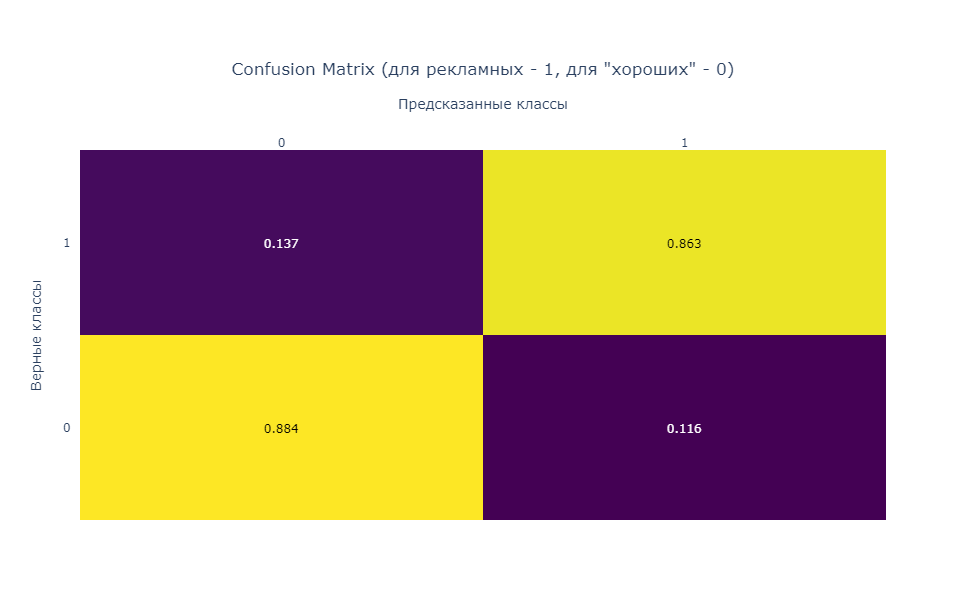

In [169]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

num_classes = 2

# Построение матрицы ошибок
fig = ff.create_annotated_heatmap(z=cm, 
                                  x=[str(i) for i in range(num_classes)], 
                                  y=[str(i) for i in range(num_classes)], 
                                  colorscale='Viridis')

fig.update_layout(
    title=dict(text='Confusion Matrix (для рекламных - 1, для "хороших" - 0)', x=0.5, xanchor='center'),
    xaxis=dict(title='Предсказанные классы', title_standoff=20),
    yaxis=dict(title='Верные классы', title_standoff=20, automargin=True),
    margin=dict(t=150),
    width=600, height=600
)

fig.show()